In [1]:
import gym, time
import numpy as np
from stable_baselines3 import SAC
from gym_unbalanced_disk import UnbalancedDisk
from gym_unbalanced_disk import *
from gym import spaces

def normalization(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi

def get_diff(theta,target):
    return 2*np.pi-np.abs(theta-target) if np.abs(theta-target)>np.pi else np.abs(theta-target)

class UnbalancedDisk_multi(UnbalancedDisk):
    """limit theta to [-pi,pi]"""
    # observation [theta,omega,target]
    def __init__(self, umax=3., dt = 0.025):
        super(UnbalancedDisk_multi, self).__init__(umax=umax, dt=dt)
        low = [-np.pi,-40.,-np.pi]
        high = [np.pi,40.,np.pi]
        weight_omega, weight_action = 0.15, 1e-3
        self.observation_space = spaces.Box(low=np.array(low,dtype=np.float32),high=np.array(high,dtype=np.float32),shape=(3,))
        self.reward_fun = lambda self: (-150*(get_diff(normalization(self.target),normalization(self.th)))**2 - weight_omega *self.omega **2 - weight_action*self.u**2).item()
        self.count = 0

    def get_obs(self):
        self.th_noise = self.th + np.random.normal(loc=0,scale=0.001) #do not edit
        self.omega_noise = self.omega + np.random.normal(loc=0,scale=0.001) #do not edit
        self.target = np.pi 
        self.target = normalization(self.target)
        self.theta = normalization(self.th_noise)
        return np.array([self.theta, self.omega_noise, self.target]) #change anything here

    def reset(self):
        self.th = np.random.normal(loc=0, scale=0.001)
        self.omega = np.random.normal(loc=0, scale=0.001)
        self.u = 0
        self.count = -1
        return self.get_obs()


In [2]:
max_episode_steps = 20000
env = UnbalancedDisk_multi(dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env, max_episode_steps=max_episode_steps)

model = SAC.load('model/SAC_multi_best.zip')

# model = SAC("MlpPolicy", env, learning_rate=0.01, verbose=1)
# model.learn(total_timesteps=5000)
# model.save('model/SAC_Multi_5000')

In [3]:
obs = env.reset()
angle_ = []
target_ = []
reward_ = []
cum_reward_ = []
cum_rew = 0
try:
    for i in range(5000):
        iteration = (i//200)%3
        if iteration == 0:
            target = np.pi
        elif iteration == 1:
            target = np.pi - np.radians(10)
        else: 
            target = np.pi + np.radians(10)
        obs[2] = normalization(target)
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        print(f'target = {obs[2]: .4f}, theta = {obs[0]: .4f}')
        time.sleep(1/120)
        angle_.append(normalization(obs[0]))
        target_.append(obs[2])
        reward_.append(reward)
        cum_rew += reward
        cum_reward_.append(cum_rew)
finally:
    env.close()

pygame 2.1.2 (SDL 2.0.18, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
target = -3.1416, theta =  0.0237
target = -3.1416, theta =  0.0907
target = -3.1416, theta =  0.1956
target = -3.1416, theta =  0.3249
target = -3.1416, theta =  0.4689
target = -3.1416, theta =  0.6188
target = -3.1416, theta =  0.7648
target = -3.1416, theta =  0.8939
target = -3.1416, theta =  1.0042
target = -3.1416, theta =  1.0905
target = -3.1416, theta =  1.1544
target = -3.1416, theta =  1.1456
target = -3.1416, theta =  1.0251
target = -3.1416, theta =  0.7940
target = -3.1416, theta =  0.4809
target = -3.1416, theta =  0.1018
target = -3.1416, theta = -0.3055
target = -3.1416, theta = -0.7141
target = -3.1416, theta = -1.0977
target = -3.1416, theta = -1.4344
target = -3.1416, theta = -1.7242
target = -3.1416, theta = -1.9652
target = -3.1416, theta = -2.1678
target = -3.1416, theta = -2.3384
target = -3.1416, theta = -2.4759
target = -3.1416, theta = -2.5855
tar

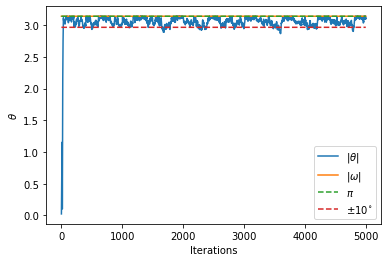

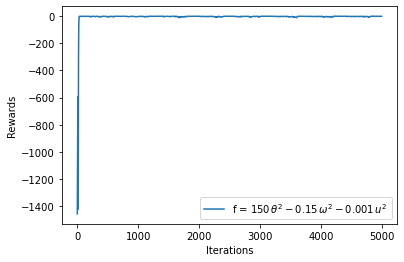

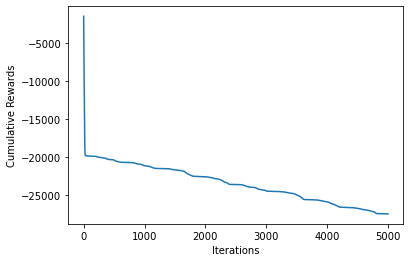

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.abs(angle_),label='$|\\theta|$')
plt.plot(np.abs(target_),label='$|\omega|$')
plt.plot([np.pi]*len(target_),'--',label='$\pi$')
plt.plot([np.pi-np.radians(10)]*len(target_),'--',label='$\pm10^{\circ}$')
plt.xlabel('Iterations')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

plt.plot(reward_, label='f = $150\,\\theta^2 - 0.15\,\omega^2 - 0.001\,u^2$')
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
plt.show()

plt.plot(cum_reward_)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()